In [1]:
# This code works in Python 3.10.6
import os.path as osp
from typing import Dict, List, Union

import torch
import torch.nn.functional as F
from torch import nn
import dgl
import torch_geometric.transforms as T
from torch_geometric.datasets import IMDB
from torch_geometric.nn import HANConv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
import random
import seaborn as sns
import torch_geometric.utils.convert
from torch import optim
from torch_geometric.data import HeteroData

from torch_geometric.nn import HeteroConv, Linear, SAGEConv

import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


In [3]:
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

Train IMDB

In [4]:
#https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/han_imdb.py

dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)


class HAN(nn.Module):
    def __init__(self, in_channels: Union[int, Dict[str, int]],
                 out_channels: int, hidden_channels=128, heads=8):
        super().__init__()
        self.han_conv = HANConv(in_channels, hidden_channels, heads=heads,
                                dropout=0.6, metadata=data.metadata())
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        out = self.han_conv(x_dict, edge_index_dict)
        out = self.lin(out['movie'])
        return out


model = HAN(in_channels=-1, out_channels=3)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train() -> float:
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['movie'].train_mask
    loss = F.cross_entropy(out[mask], data['movie'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test() -> List[float]:
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['movie'][split]
        acc = (pred[mask] == data['movie'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


best_val_acc = 0
start_patience = patience = 100
for epoch in range(1, 100):

    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

    if best_val_acc <= val_acc:
        patience = start_patience
        best_val_acc = val_acc
    else:
        patience -= 1

    if patience <= 0:
        print('Stopping training as validation accuracy did not improve '
              f'for {start_patience} epochs')
        break

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)
Epoch: 010, Loss: 0.7420, Train: 0.9000, Val: 0.5650, Test: 0.5204
Epoch: 020, Loss: 0.3455, Train: 0.9825, Val: 0.6275, Test: 0.5736
Epoch: 030, Loss: 0.1963, Train: 0.9975, Val: 0.6200, Test: 0.5696
Epoch: 040, Loss: 0.1644, Train: 1.0000, Val: 0.6400, Test: 0.5667
Epoch: 050, Loss: 0.1516, Train: 1.0000, Val: 0.6200, Test: 0.5664
Epoch: 060, Loss: 0.1221, Train: 1.0000, Val: 0.6100, Test: 0.5653
Epoch: 070, Loss: 0.1145, Train: 1.0000, Val: 0.6100, Test: 0.5627
Epoch: 080, Loss: 0.1017, Train: 1.0000, Val: 0.6150, Test: 0.5730
Epoch: 090, Loss: 0.0928, Train: 1.0000, Val: 0.6000, Test: 0.5725


Graph (without node features) generated from HGEN

In [5]:
G = nx.read_gexf("IMDB_movie_hgen.gexf")

Adding node features to graph

importing Jupyter notebook from imdb_gmm_features.ipynb
no of class movie0 node samples - 242
no of class movie1 node samples - 242
no of class movie2 node samples - 242
no of class director node samples - 410
no of class actor node samples - 494


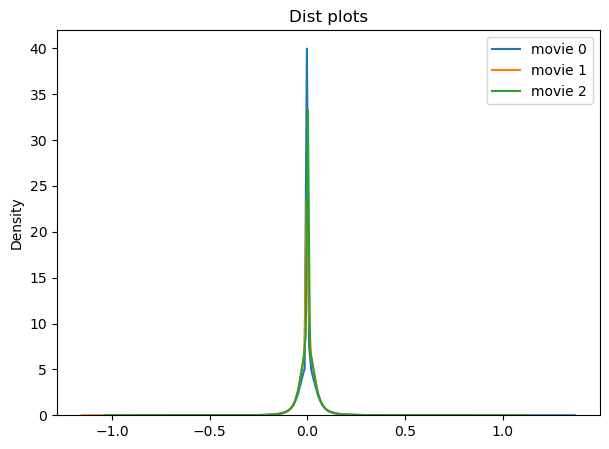

In [6]:
#Load node features 
import import_ipynb
import imdb_gmm_features

In [7]:
movie_node_features = imdb_gmm_features.movie_node_features
director_node_features = imdb_gmm_features.director_node_features
actor_node_features = imdb_gmm_features.actor_node_features

In [8]:
movie_node_features

,nodeId,0,1,2,3,4,5,6,7,8,...,3057,3058,3059,3060,3061,3062,3063,3064,3065,class
0,904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,1625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
722,1626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
723,1627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
724,1628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [9]:
director_node_features

,nodeId,0,1,2,3,4,5,6,7,8,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0,-0.004341,0.010031,0.004349,0.021421,0.012387,-0.004304,-0.000562,0.010982,0.022044,...,0.029979,0.047099,-0.035381,0.006271,0.004409,0.008728,0.000975,-0.068279,-0.004493,-0.000030
1,1,-0.002145,0.032397,0.001800,0.000064,-0.008721,-0.007131,0.035914,0.006462,-0.025909,...,-0.025423,0.016966,-0.053783,-0.007152,0.031797,0.011405,-0.006467,0.158869,-0.007367,0.011213
2,2,0.001760,-0.009854,0.005977,-0.034355,-0.004669,-0.003765,0.056458,0.009686,0.000163,...,-0.029751,-0.019215,0.080024,-0.026595,0.001871,0.023389,-0.010769,0.081238,0.000696,-0.004089
3,3,-0.011001,-0.003619,-0.007071,0.002586,-0.004204,0.003032,-0.004193,-0.015750,0.028074,...,-0.026030,0.027105,0.029672,0.019000,0.013027,-0.006853,-0.007902,0.050721,-0.002424,-0.001460
4,4,-0.007657,0.009114,0.002259,0.020284,-0.008179,0.002011,0.023391,-0.031082,-0.012892,...,0.024297,-0.032544,0.071521,0.003423,0.014291,-0.010077,0.005556,0.031530,-0.004444,-0.004365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,405,0.004420,0.011863,-0.010257,0.009904,-0.012943,-0.002052,0.005830,-0.008939,-0.000762,...,-0.005104,0.038757,0.061127,0.008846,-0.045060,0.010927,0.006363,0.101769,-0.003400,-0.006426
406,406,-0.004484,0.000200,0.003108,0.000566,0.009379,-0.009169,-0.021727,0.001815,0.036927,...,0.011258,0.056802,0.059716,-0.032127,0.011860,0.009172,0.002984,0.072967,0.014915,-0.005118
407,407,-0.003347,-0.013643,0.017842,-0.012130,0.014162,0.009503,0.011590,0.022851,0.023564,...,-0.014317,0.047852,0.006591,-0.054939,0.004870,-0.001845,0.015634,0.128551,0.016955,0.004752
408,408,-0.002140,-0.024811,-0.020008,0.024866,0.015491,0.009992,0.005992,0.013581,0.069334,...,-0.002263,0.018929,-0.035099,0.023208,-0.055417,0.004585,0.005067,0.151117,0.013666,-0.001541


In [10]:
actor_node_features

,nodeId,0,1,2,3,4,5,6,7,8,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,410,-0.019738,0.007027,-0.041063,0.006349,0.003781,0.019081,-0.003313,-0.028191,-0.022735,...,0.017451,0.012501,0.002659,-0.013747,0.005679,-0.007995,-0.016807,-0.155896,0.000859,-0.009668
1,411,0.018394,-0.001326,0.021021,-0.012638,0.003726,0.058079,0.003104,-0.014543,-0.037013,...,0.026826,0.018168,-0.014468,-0.003089,0.009954,0.001247,0.004262,-0.093691,-0.005971,-0.051190
2,412,-0.022016,-0.050622,0.006466,-0.018942,-0.027440,0.014319,-0.008862,0.011928,-0.037594,...,-0.001115,-0.025491,-0.017222,-0.014849,0.011751,-0.057410,0.000268,0.248265,0.002084,0.008547
3,413,-0.008323,-0.043731,-0.008492,0.024046,0.008840,-0.038919,0.020235,-0.010637,0.047453,...,-0.027786,-0.015502,0.040001,0.020890,-0.015281,0.022724,0.001897,0.052227,-0.010454,0.023096
4,414,-0.027655,-0.012613,-0.016675,0.003558,-0.025939,-0.029911,0.029165,0.015828,-0.045303,...,0.026916,-0.045314,-0.015953,-0.007184,0.056829,0.013309,-0.007946,-0.007178,0.007356,0.004151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,899,0.017183,0.014473,0.037979,0.002966,-0.000252,0.007878,0.016880,-0.019032,-0.002736,...,0.056764,0.041122,-0.064509,0.017776,-0.011553,-0.003436,0.001723,-0.008801,0.006458,-0.010539
490,900,0.018623,-0.002734,0.038173,-0.003963,0.015681,0.001209,-0.018090,-0.014866,0.037133,...,0.018312,-0.047826,0.054372,0.005889,-0.010637,-0.036860,0.006744,-0.095448,-0.001128,-0.023428
491,901,-0.004427,-0.030055,-0.015609,-0.018527,-0.001776,-0.013350,-0.005433,-0.010728,0.036408,...,-0.014758,0.025545,0.009672,-0.054168,-0.033361,0.063865,0.026967,0.139740,-0.002615,0.010742
492,902,0.007949,0.029294,0.009006,0.003624,0.005753,0.010977,0.015160,0.036298,0.000400,...,0.002577,0.033591,0.019959,-0.023718,-0.013187,0.030934,0.010292,0.208463,-0.000241,0.013926


In [11]:
 #Adding node degree
for node in G.nodes():
    d = G.degree(node)
    G.nodes[node]["degree"] = d

In [12]:
#Generate graphs of 2-hop neighbourhood
def graph_gen(nodeid):
    
    num_hops = 2  
    nodes = []
    edges = []
    #Get small graph nodes
    nodes = nx.single_source_shortest_path_length(G, nodeid, cutoff=num_hops).keys() 
    if 3 <= len(nodes) <= 200:
        graph = nx.ego_graph(G,nodeid, num_hops, center=True,undirected = True)
        #Get small graph edges
        edges = [e for e in graph.edges]
        #nx.draw(graph, with_labels = True)
        #plt.show()
        #print('nodeid',nodeid)
        #print('node count',len(nodes))
        #print('edge count',len(edges))
        return nodes, edges
    else:
        return None, None

In [13]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [14]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [15]:
def get_node_type(node_id):
    if (int(node_id) in list(movie_node_features['nodeId'])):
        return 'movie'
    elif (int(node_id) in list(director_node_features['nodeId'])):
        return 'director'
    elif (int(node_id) in list(actor_node_features['nodeId'])):
        return 'actor'
    else:
        return 'genre'


In [16]:
all_edges = {}

In [17]:
#List of edges in metagraph of IMDB
list(meta_g.edges())

[('actor', 'movie'),
 ('movie', 'actor'),
 ('movie', 'director'),
 ('director', 'movie')]

In [18]:
def create_dataset(nodes,edges,movie_node_features,director_node_features,actor_node_features,node_id):
    
    movie_df = movie_node_features[movie_node_features["nodeId"].isin([int(x) for x in nodes])]
    director_df = director_node_features[director_node_features["nodeId"].isin([int(x) for x in nodes])]
    actor_df = actor_node_features[actor_node_features["nodeId"].isin([int(x) for x in nodes])]
    
    #Nodes   
    movie = np.asarray(movie_df.drop(columns=['nodeId','class']))
    director = np.asarray(director_df.drop(columns=['nodeId']))
    actor = np.asarray(actor_df.drop(columns=['nodeId']))
    
    x_movie = torch.tensor(movie).to(dtype=torch.float32)
    y_movie = torch.tensor(np.array(movie_df["class"]), dtype=torch.long)
    x_director = torch.tensor(director).to(dtype=torch.float32)
    x_actor = torch.tensor(actor).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))
    
    movie_to_director = []
    director_to_movie = []
    movie_to_actor = []
    actor_to_movie = []
    remaining_edges = []
   
    for i in range(len(edges)):

        if (int(source[i]) in list(movie_df['nodeId'])) and (int(dest[i]) in list(director_df['nodeId'])):
            movie_to_director.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(movie_df['nodeId'])) and (int(dest[i]) in list(actor_df['nodeId'])):
            movie_to_actor.append((int(source[i]),int(dest[i]))) 
            
        elif (int(source[i]) in list(director_df['nodeId'])) and (int(dest[i]) in list(movie_df['nodeId'])):
            director_to_movie.append((int(source[i]),int(dest[i]))) 
            
        elif (int(source[i]) in list(actor_df['nodeId'])) and (int(dest[i]) in list(movie_df['nodeId'])):
            actor_to_movie.append((int(source[i]),int(dest[i])))

        else:
            #The edges not present in the metagraph  
            source_node_type = get_node_type(source[i])
            dest_node_type = get_node_type(dest[i])
            remaining_edges.append((source_node_type,dest_node_type))
            #remaining_edges.append((int(source[i]),int(dest[i])))
    
    
    all_edges[node_id] = [*movie_to_director,*movie_to_actor,*director_to_movie,*actor_to_movie]
               
    #Re-map indices to correct range
    movie_nodes_mapping = remap_indices(list(movie_df["nodeId"]))
    director_nodes_mapping = remap_indices(list(director_df["nodeId"]))
    actor_nodes_mapping = remap_indices(list(actor_df["nodeId"]))
    
    node_list = {}
    for d in [movie_nodes_mapping, director_nodes_mapping, actor_nodes_mapping]:
        node_list.update(d)
    
    #Create Hetero Data      
    small_graph = HeteroData({'movie':{'x': x_movie, 'y':y_movie}, 
                              'director':{'x': x_director},'actor':{'x': x_actor}})
    
    if movie_to_director:
        edge_index_movie_director = preprocess_edges(movie_to_director,node_list)
        small_graph['movie','to','director'].edge_index = edge_index_movie_director
        
    if director_to_movie:
        edge_index_director_movie = preprocess_edges(director_to_movie,node_list)
        small_graph['director','to','movie'].edge_index = edge_index_director_movie
    
    if actor_to_movie:
        edge_index_actor_movie = preprocess_edges(actor_to_movie,node_list)
        small_graph['actor','to','movie'].edge_index = edge_index_actor_movie
        
    if movie_to_actor:
        edge_index_movie_actor = preprocess_edges(movie_to_actor,node_list)
        small_graph['movie','to','actor'].edge_index = edge_index_movie_actor
        

    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)
    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
    
    return small_graph, remaining_edges

In [19]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['movie'].test_mask
        correct = (pred[mask] == small_graph['movie'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['movie'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [20]:
n_list = dict((n,d['degree']) for n,d in G.nodes().items() if d['degree']>=2)
print('No of 2-hop graphs:',len(n_list))
#n_list= random.sample(node_subset.keys(), 500)

No of 2-hop graphs: 511


In [21]:
softmax_dict = {}
nodefeature_dict = {}
original_edge_count = []
removed_edge_count = []
removed_edges_list = []
for nodeid in n_list: 
    #Generate small Graphs
    nodes, edges = graph_gen(nodeid)
    if not (nodes is None):
        
        small_graph_data, removed_edges = create_dataset(nodes,edges,
                              movie_node_features,director_node_features,
                              actor_node_features,nodeid)
        
        edge_list = all_edges[nodeid]
        graph = nx.Graph(edge_list)
        if not nx.is_empty(graph) and nx.is_connected(graph):

                
            if (small_graph_data['movie'].x.nelement()!=0) and \
            (small_graph_data['actor','to','movie']) :

                print('nodeid',nodeid)
                print('node count',small_graph_data.num_nodes)
                print('edge count',small_graph_data.num_edges)

                original_edge_count.append(len(edges))
                removed_edge_count.append(len(removed_edges))
                removed_edges_list.append(set(removed_edges))
                print('Original edge_count',len(edges))
                print('Removed edge_count',len(removed_edges))
                print('Removed edges',removed_edges)

                #graph = nx.ego_graph(G,nodeid, 2, center=True,undirected = True)
                #nx.draw(graph, with_labels = True)
                #plt.show() 

                #Evaluate trained IMDB on smaller graphs

                softmax, correct_indices = evaluate_gnn(small_graph_data)
                softmax_dict[nodeid] = softmax
                nodefeature_dict[nodeid]={'movie':small_graph_data['movie'].x[correct_indices],
                                         'director':small_graph_data['director'].x,
                                         'actor':small_graph_data['actor'].x}
                #print(small_graph_data)

            else:
                #print("The next graph could not be evaluated. Required edges are missing.")
                pass

    else:
        #print("The next graph could not be loaded. Node count is less than 3")
        pass
        

nodeid 183
node count 4
edge count 3
Original edge_count 15
Removed edge_count 12
Removed edges [('genre', 'movie'), ('genre', 'genre'), ('genre', 'genre'), ('movie', 'genre'), ('movie', 'genre'), ('movie', 'genre'), ('movie', 'genre'), ('movie', 'genre'), ('genre', 'genre'), ('genre', 'genre'), ('genre', 'genre'), ('genre', 'genre')]
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2],
  },
  director={ x=[1, 3066] },
  actor={ x=[1, 3066] },
  (director, to, movie)={ edge_index=[2, 2] },
  (actor, to, movie)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 2])
Ground Truth: tensor([0, 0])
tensor([False, False])
tensor([[3.9399e-04, 6.6458e-03, 9.9296e-01],
        [2.8942e-03, 5.1487e-02, 9.4562e-01]])
correct indices []
------------------------------------------------------------------
nodeid 382
node count 4
edge count 3
Original edge_count 10
Removed edge_count 7
Removed edges [('genre', 'movie'), ('genre', 'genre'), ('movie', 'g

In [22]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  64


In [23]:
print('Average number of original edges',round(np.mean(original_edge_count)))

Average number of original edges 154


In [24]:
print('Average number of edges removed',round(np.mean(removed_edge_count)))

Average number of edges removed 152


In [25]:
#The edges that are removed across all graphs
print('Edges removed', set.union(*removed_edges_list))

Edges removed {('actor', 'genre'), ('movie', 'genre'), ('genre', 'genre'), ('genre', 'actor'), ('director', 'genre'), ('genre', 'director'), ('genre', 'movie'), ('movie', 'movie')}


In [27]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}

for nodeid in softmax_dict:
    list0= []
    list1= []
    list2= []

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []


        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 


     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:
        prob_class2_dict[nodeid]=max(list2)


Getting the highest prediction probability for each class of author node

In [28]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())

In [29]:
# Getting nodeid to re-generate 2 hop graph which maximizes prediction
class0_nodeid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_nodeid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_nodeid = max(prob_class2_dict, key=prob_class2_dict.get)

In [30]:
def plot_graph(nodeid, max_pred,nodetype,edges):

    classes = []
    graph = nx.Graph(edges)
    for g in graph.nodes():
        if g in list(movie_node_features['nodeId']):
            classes.append(2)
        elif g in list(director_node_features['nodeId']):
            classes.append(0)
        elif g in list(actor_node_features['nodeId']):
            classes.append(1)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen'}
    
    nx.set_node_attributes(graph, dict(zip(graph.nodes(), classes)), 'class')
    
    print('Number of nodes: ',graph.number_of_nodes())
    print('nodeid for generating 2 hop graph: ',nodeid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(graph, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in graph.nodes(data=True)], 
        node_size=100,
        font_color='black')
    plt.show()

In [31]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [64]:
plt.rcParams.update({'axes.ymargin': 0.2})

In [69]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('feature values',fontsize=20)
    plt.ylabel('feature count',fontsize=20)

    plt.show()


Plotting explanation graphs and node features for each class of movie node

Node colors:

Director - Blue

Actor - Red

Movie - Darkgreen


Number of nodes:  4
nodeid for generating 2 hop graph:  989
Max pred probability for class 0 is 0.9033820629119873


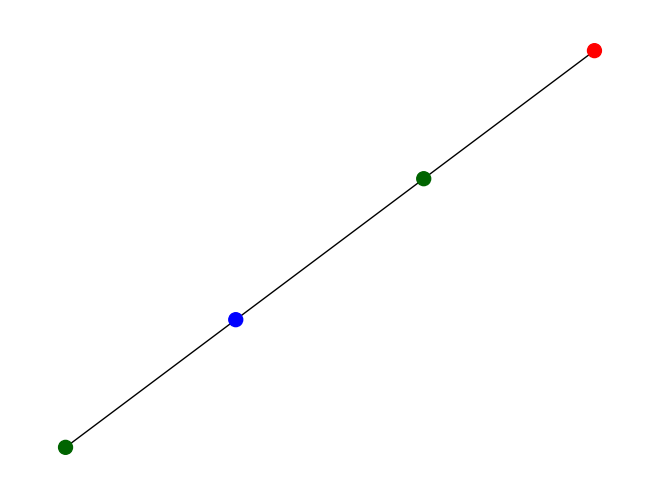

In [33]:
explanation_graph0 = plot_graph(class0_nodeid, max_pred0, 0, all_edges[class0_nodeid])

In [34]:
ind0= index_2d(softmax_dict[class0_nodeid], max_pred0)[0]

In [35]:
list0= nodefeature_dict[class0_nodeid]['movie'].numpy()[ind0]

In [36]:
Counter(list0)

Counter({0.0: 3065, 3.0: 1})

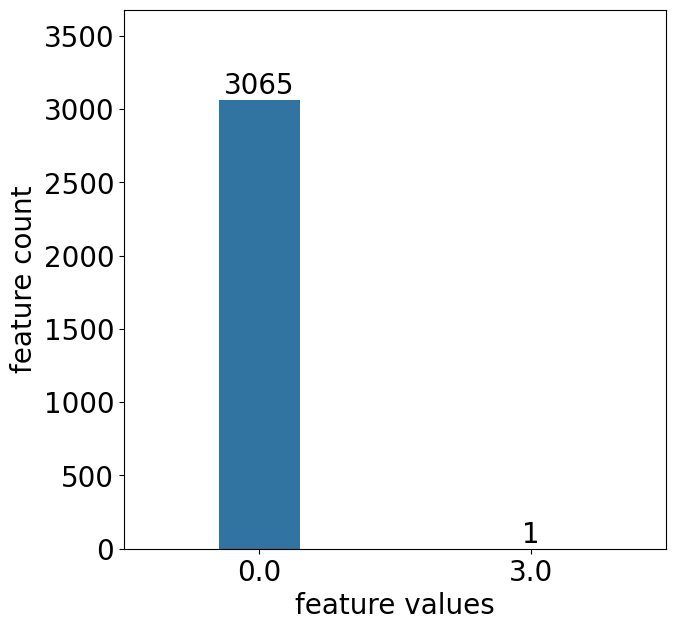

In [70]:
count_plot(list0)

Number of nodes:  4
nodeid for generating 2 hop graph:  726
Max pred probability for class 1 is 0.9991357922554016


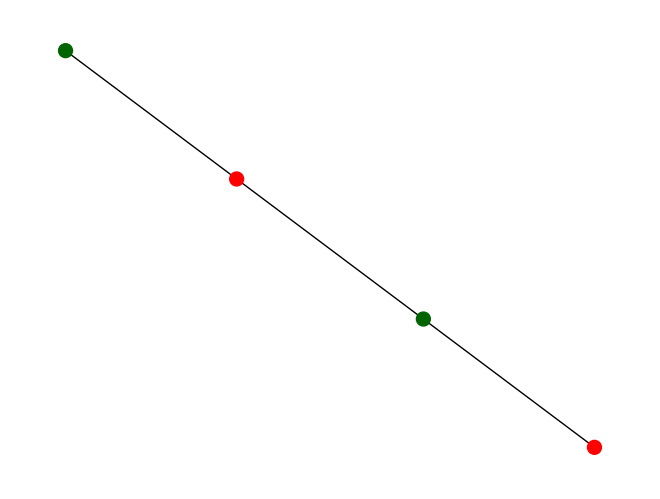

In [38]:
explanation_graph1 = plot_graph(class1_nodeid, max_pred1, 1,all_edges[class1_nodeid])

In [39]:
ind1= index_2d(softmax_dict[class1_nodeid], max_pred1)[0]

In [40]:
list1= nodefeature_dict[class1_nodeid]['movie'].numpy()[ind1]

In [41]:
Counter(list1)

Counter({0.0: 3066})

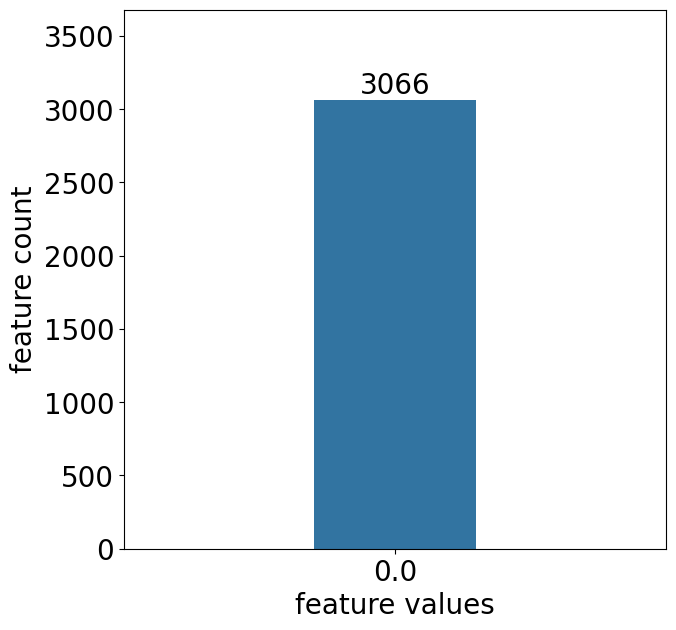

In [72]:
count_plot(list1)

Number of nodes:  2
nodeid for generating 2 hop graph:  787
Max pred probability for class 2 is 0.992395281791687


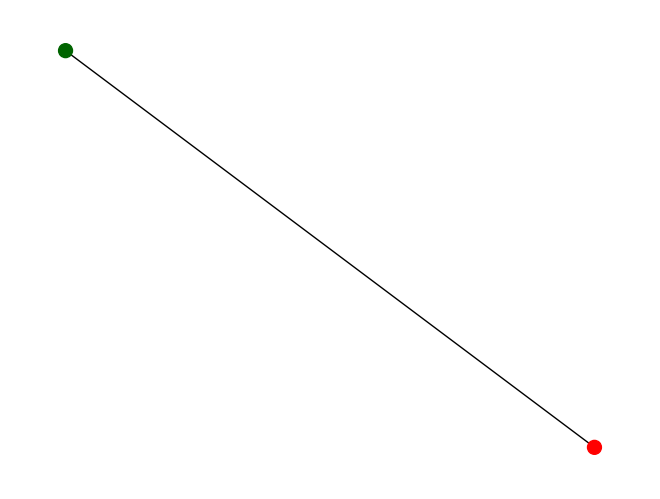

In [43]:
explanation_graph2 = plot_graph(class2_nodeid, max_pred2, 2,all_edges[class2_nodeid])

In [44]:
ind2= index_2d(softmax_dict[class2_nodeid], max_pred2)[0]

In [45]:
list2= nodefeature_dict[class2_nodeid]['movie'].numpy()[ind2]

In [46]:
Counter(list2)

Counter({0.0: 3065, 2.0: 1})

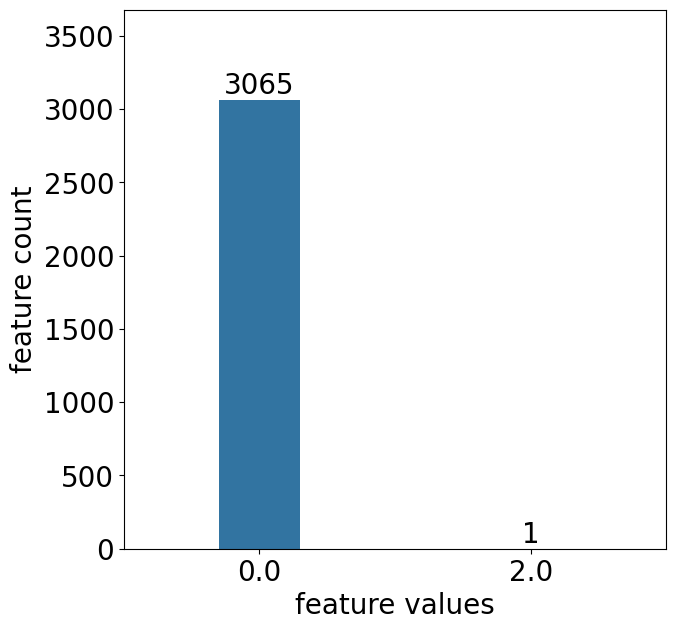

In [73]:
count_plot(list2)

In [48]:
def print_stat_cont_features(df):
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [49]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show()  

In [50]:
#Actor
actor0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['actor'].numpy())
print_stat_cont_features(actor0_df)

mean 0.0029702713
std dev 0.040241294


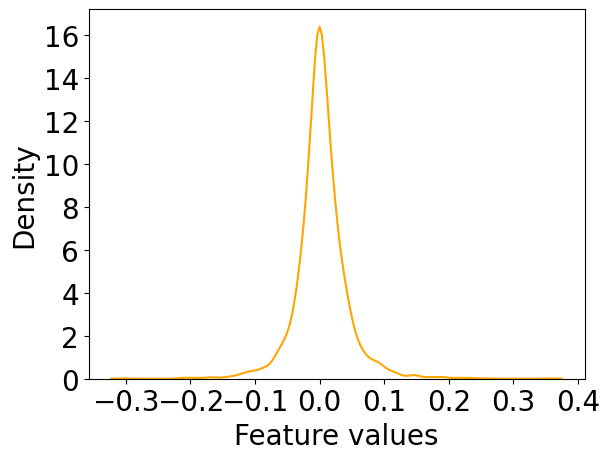

In [51]:
plot_node_feat(actor0_df)

In [52]:
actor1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['actor'].numpy())
print_stat_cont_features(actor1_df)

mean 0.0013947528
std dev 0.042558122


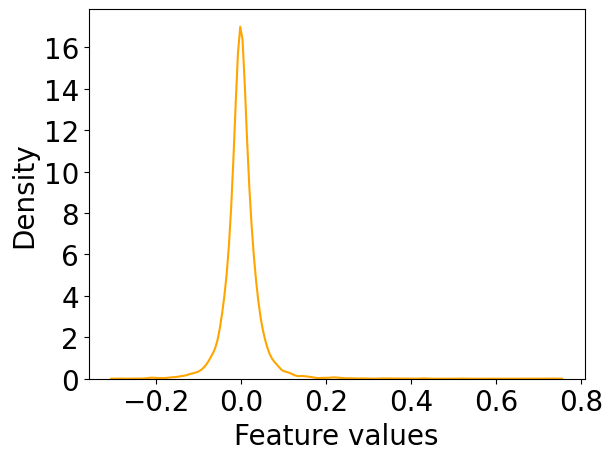

In [53]:
plot_node_feat(actor1_df)

In [54]:
actor2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['actor'].numpy())
print_stat_cont_features(actor2_df)

mean 0.0018999267
std dev 0.04306489


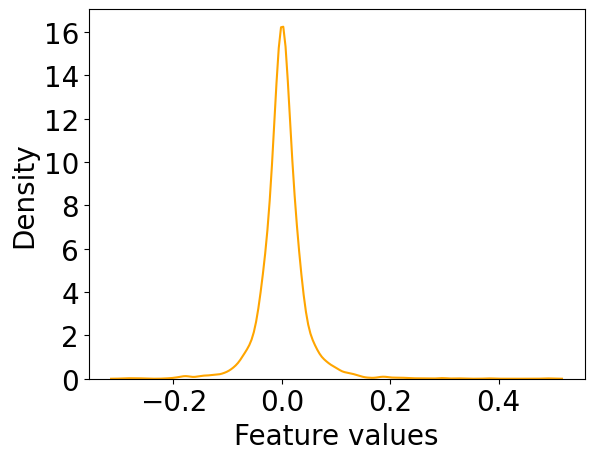

In [55]:
plot_node_feat(actor2_df)

In [56]:
#Director
director0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['director'].numpy())
print_stat_cont_features(director0_df)

mean 0.0013960032
std dev 0.040608868


Text(0, 0.5, 'Density')

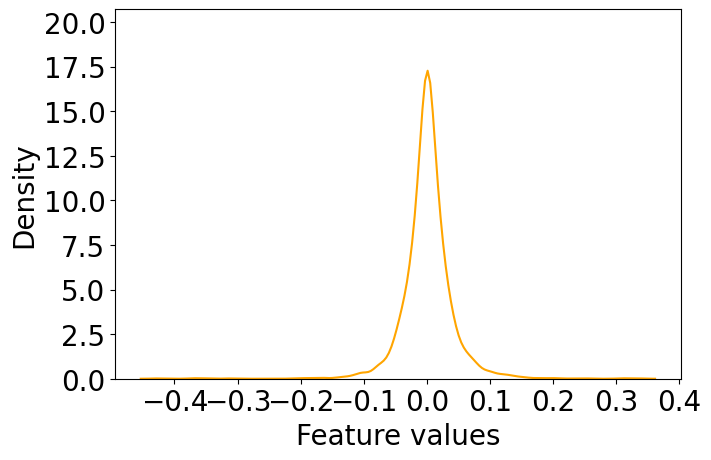

In [76]:
#plot_node_feat(director0_df)
fig, ax = plt.subplots(figsize=(7.3,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(director0_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)